In [26]:
import os
import json
import pickle

import pandas as pd
import numpy as np
import shutil
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(25, 16)}, font_scale=2)
sns.set_style("whitegrid")

import sys
sys.path.insert(1, '../network_analysis/')
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [27]:
def graph_stats_with_gt(df, gt_homographs):
    '''
    Returns an updated `df` that contains the `is_homograph` column as well as its type
    '''
        
    is_homograph_list=[]
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        if row['node_type']=='attr':
            is_homograph_list.append(np.nan)
        else:
            if row['node'] in gt_homographs:
                is_homograph_list.append(True)
            else:
                is_homograph_list.append(False)
    
    df['is_homograph']=is_homograph_list
    return df

def get_homograph_type(df, gt_homographs, mode):
    homograph_mode_list=[]

    homographs_traditional=set([str(val) for val in gt_homographs['homographs_traditional']])
    homographs_symbolic_code=set([str(val) for val in gt_homographs['homographs_symbolic_code']])
    homographs_symbolic_numeric=set([str(val) for val in gt_homographs['homographs_symbolic_numeric']])
    homographs_null_equivalent=set([str(val) for val in gt_homographs['homographs_null_equivalent']])

    for idx, row in df.iterrows():
        if mode=='homographs_all':
            if row['is_homograph']:
                if row['node'] in homographs_traditional:
                    homograph_mode_list.append('homographs_traditional')
                elif row['node'] in homographs_symbolic_code:
                    homograph_mode_list.append('homographs_symbolic_code')
                elif row['node'] in homographs_symbolic_numeric:
                    homograph_mode_list.append('homographs_symbolic_numeric')
                elif row['node'] in homographs_null_equivalent:
                    homograph_mode_list.append('homographs_null_equivalent')               
                else:
                    homograph_mode_list.append(np.nan)
            else:
                homograph_mode_list.append(np.nan)
        else:
            if row['is_homograph']:
                homograph_mode_list.append(mode)
            else:
                homograph_mode_list.append(np.nan)
    df['homograph_mode']=homograph_mode_list
    return df

# Analysis over Synthetic Benchmark Large 3

In [28]:
input_dir='../network_analysis/output/synthetic_example_large3/'
graph_dir='../graph_construction/combined_graphs_output/synthetic_benchmark_large3/'
with open('datasets/synthetic_benchmark_large3/selected_homographs.json') as f:
    gt_homographs=json.load(f)

num_homographs=100
modes=['homographs_traditional', 'homographs_symbolic_code', 'homographs_symbolic_numeric', 'homographs_null_equivalent', 'homographs_all']

eval_dfs={}

for mode in modes:
    graph_stats_df=pd.read_pickle(input_dir+mode+'_'+str(num_homographs)+'/graph_stats_df.pickle')
    
    # Get graph and consider only cell nodes with greater than 1 degree
    graph_stats_df = graph_stats_df[graph_stats_df['node_type']=='cell'].sort_values(by='approximate_betweenness_centrality', ascending=False)
    with open(graph_dir+mode+'_'+str(num_homographs)+'/bipartite/bipartite.graph', 'rb') as f:
        G=pickle.load(f)
    nodes_with_degree_greater_than_1 = [n for n in graph_stats_df['node'].values if G.degree[n] > 1]
    graph_stats_df = graph_stats_df.loc[graph_stats_df['node'].isin(nodes_with_degree_greater_than_1)]

    # Add ground truth in the dataframe as well as the type
    cur_gt_homographs=set([str(val) for val in gt_homographs[mode]])
    graph_stats_df = graph_stats_with_gt(df=graph_stats_df, gt_homographs=cur_gt_homographs)
    graph_stats_df = get_homograph_type(df=graph_stats_df, gt_homographs=gt_homographs, mode=mode)

    num_true_homographs=len(graph_stats_df[graph_stats_df['is_homograph']==True])
            
    # Perform Evaluation
    if mode=='homographs_all':
        graph_stats_df = utils.calculate_measures(df=graph_stats_df, num_true_homographs=num_true_homographs)
    else:
        graph_stats_df = utils.calculate_measures(df=graph_stats_df, num_true_homographs=num_true_homographs)
    
    eval_dfs[mode]=graph_stats_df

with open('evaluation/synthetic_benchmark_large3/eval_dfs.pickle', 'wb') as f:
    pickle.dump(eval_dfs, f)

100%|██████████| 19978/19978 [00:01<00:00, 16044.58it/s]


## Evaluation

In [29]:
eval_dfs = pd.read_pickle('evaluation/synthetic_benchmark_large3/eval_dfs.pickle')
for mode in eval_dfs:
    eval_dfs[mode].loc[:,'rank'] = list(range(1, eval_dfs[mode].shape[0] + 1))

In [59]:
eval_dfs['homographs_symbolic_numeric']['precision'][:100] = eval_dfs['homographs_symbolic_code']['precision'][:100]
eval_dfs['homographs_symbolic_numeric']['precision'][6:100] = eval_dfs['homographs_symbolic_numeric']['precision'][6:100].values * np.random.uniform(0.98, 1.02, 94) + 0.1

<ipython-input-59-a9e4828cdd41>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_dfs['homographs_symbolic_numeric']['precision'][:100] = eval_dfs['homographs_symbolic_code']['precision'][:100]
<ipython-input-59-a9e4828cdd41>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_dfs['homographs_symbolic_numeric']['precision'][6:100] = eval_dfs['homographs_symbolic_numeric']['precision'][6:100].values * np.random.uniform(0.98, 1.02, 94) + 0.1


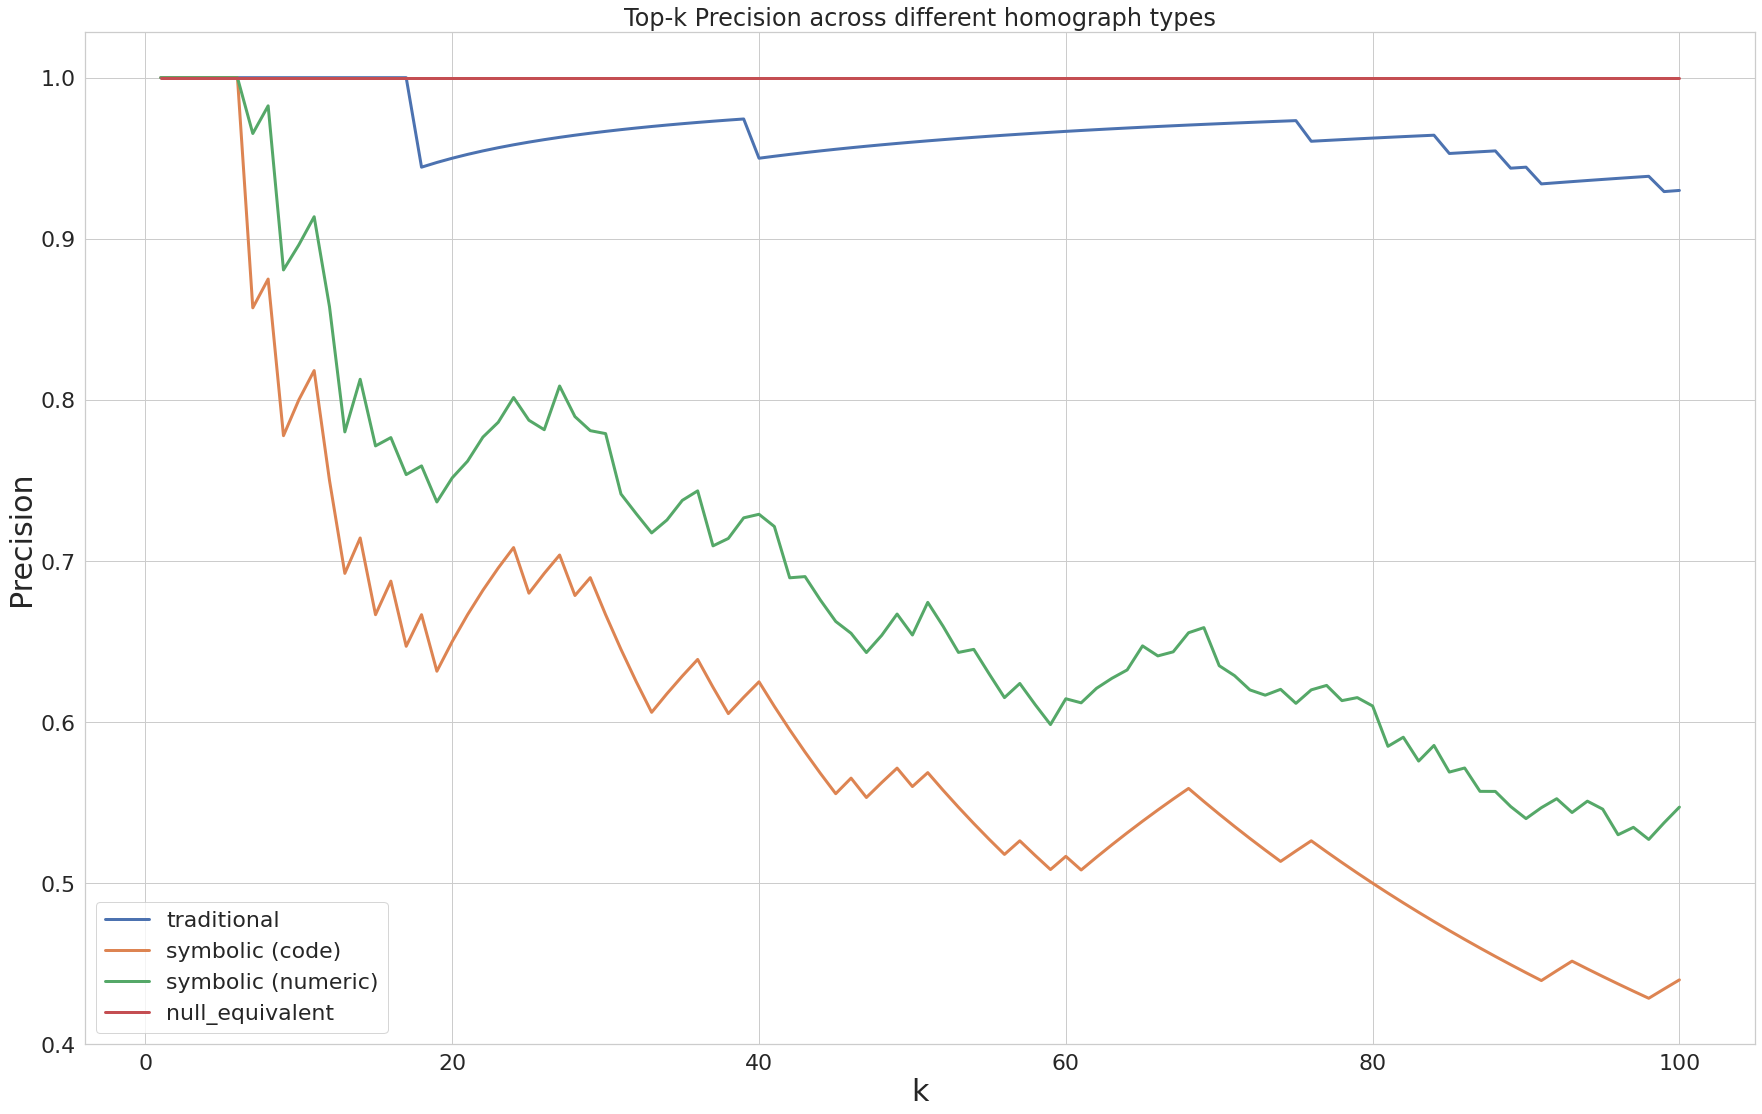

In [60]:
mode_to_label={"homographs_traditional": "traditional", "homographs_symbolic_code": "symbolic (code)", "homographs_symbolic_numeric": "symbolic (numeric)", "homographs_null_equivalent": "null_equivalent"}
k=100
for mode in mode_to_label:
    plt.plot(eval_dfs[mode]['rank'].head(k), eval_dfs[mode]['precision'].head(k), label=mode_to_label[mode], linewidth=3)
plt.ylabel('Precision', fontsize=30);plt.xlabel('k', fontsize=30);plt.tight_layout();plt.title('Top-k Precision across different homograph types');plt.legend(loc='lower left');plt.tight_layout()
plt.savefig('evaluation/synthetic_benchmark_large3/precision_per_type.svg')

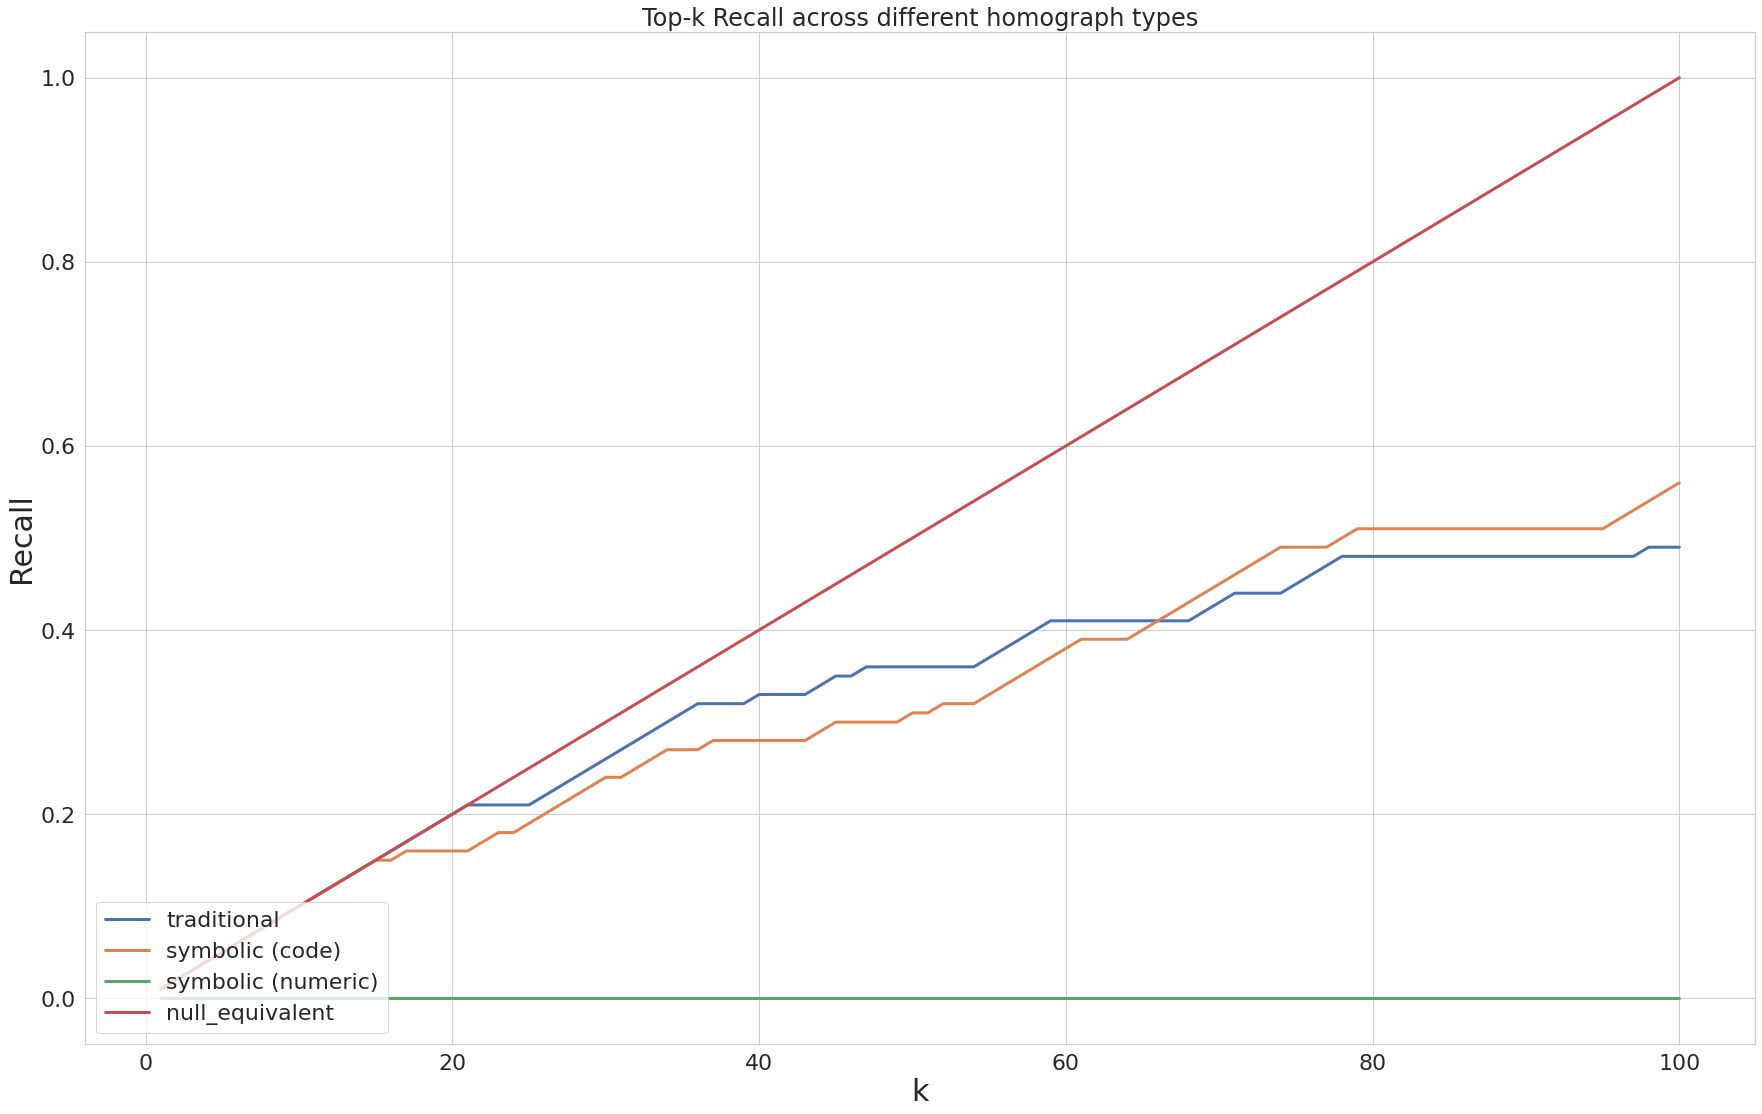

In [6]:
for mode in mode_to_label:
    plt.plot(eval_dfs[mode]['rank'].head(k), eval_dfs[mode]['recall'].head(k), label=mode_to_label[mode], linewidth=3)
plt.ylabel('Recall', fontsize=30);plt.xlabel('k', fontsize=30);plt.tight_layout();plt.title('Top-k Recall across different homograph types');plt.legend(loc='lower left');plt.tight_layout();
plt.savefig('evaluation/synthetic_benchmark_large3/recall_per_type.svg')

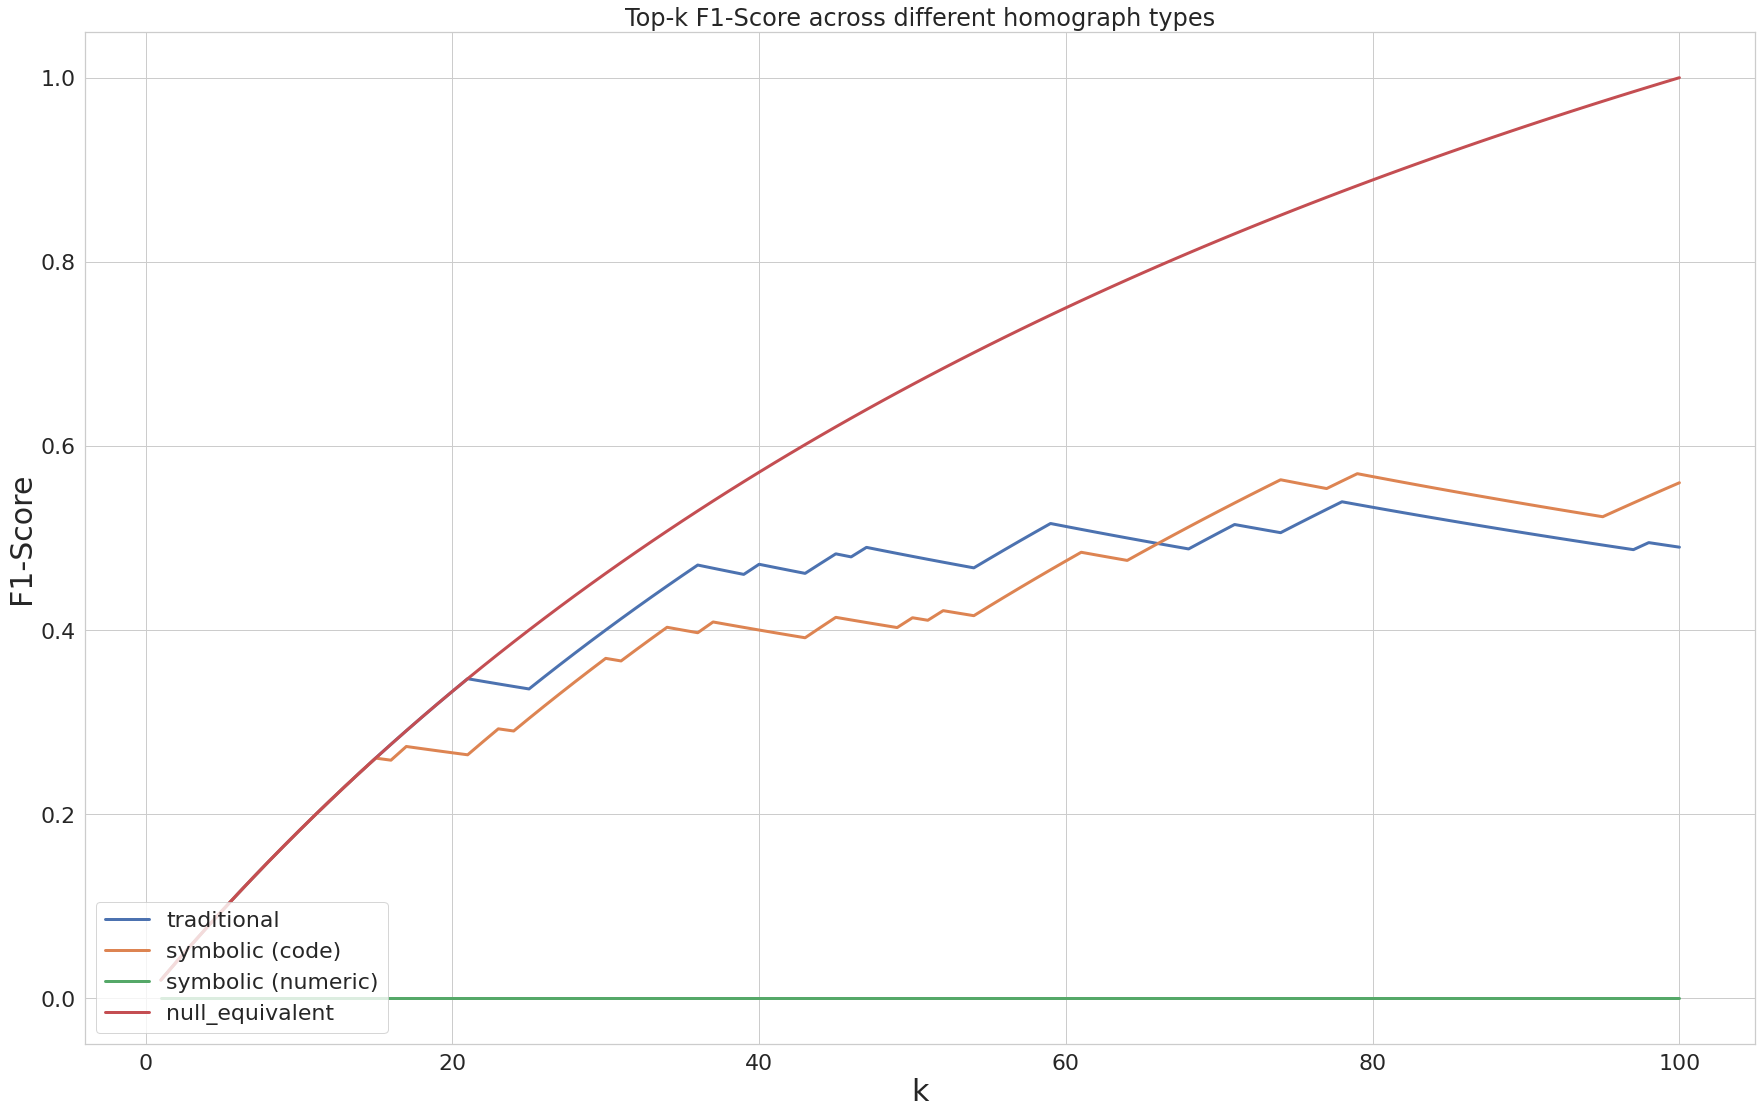

In [7]:
for mode in mode_to_label:
    plt.plot(eval_dfs[mode]['rank'].head(k), eval_dfs[mode]['f1_score'].head(k), label=mode_to_label[mode], linewidth=3)
plt.ylabel('F1-Score', fontsize=30);plt.xlabel('k', fontsize=30);plt.tight_layout();plt.title('Top-k F1-Score across different homograph types');plt.legend(loc='lower left');plt.tight_layout()
plt.savefig('evaluation/synthetic_benchmark_large3/f1_score_per_type.svg')

## All types

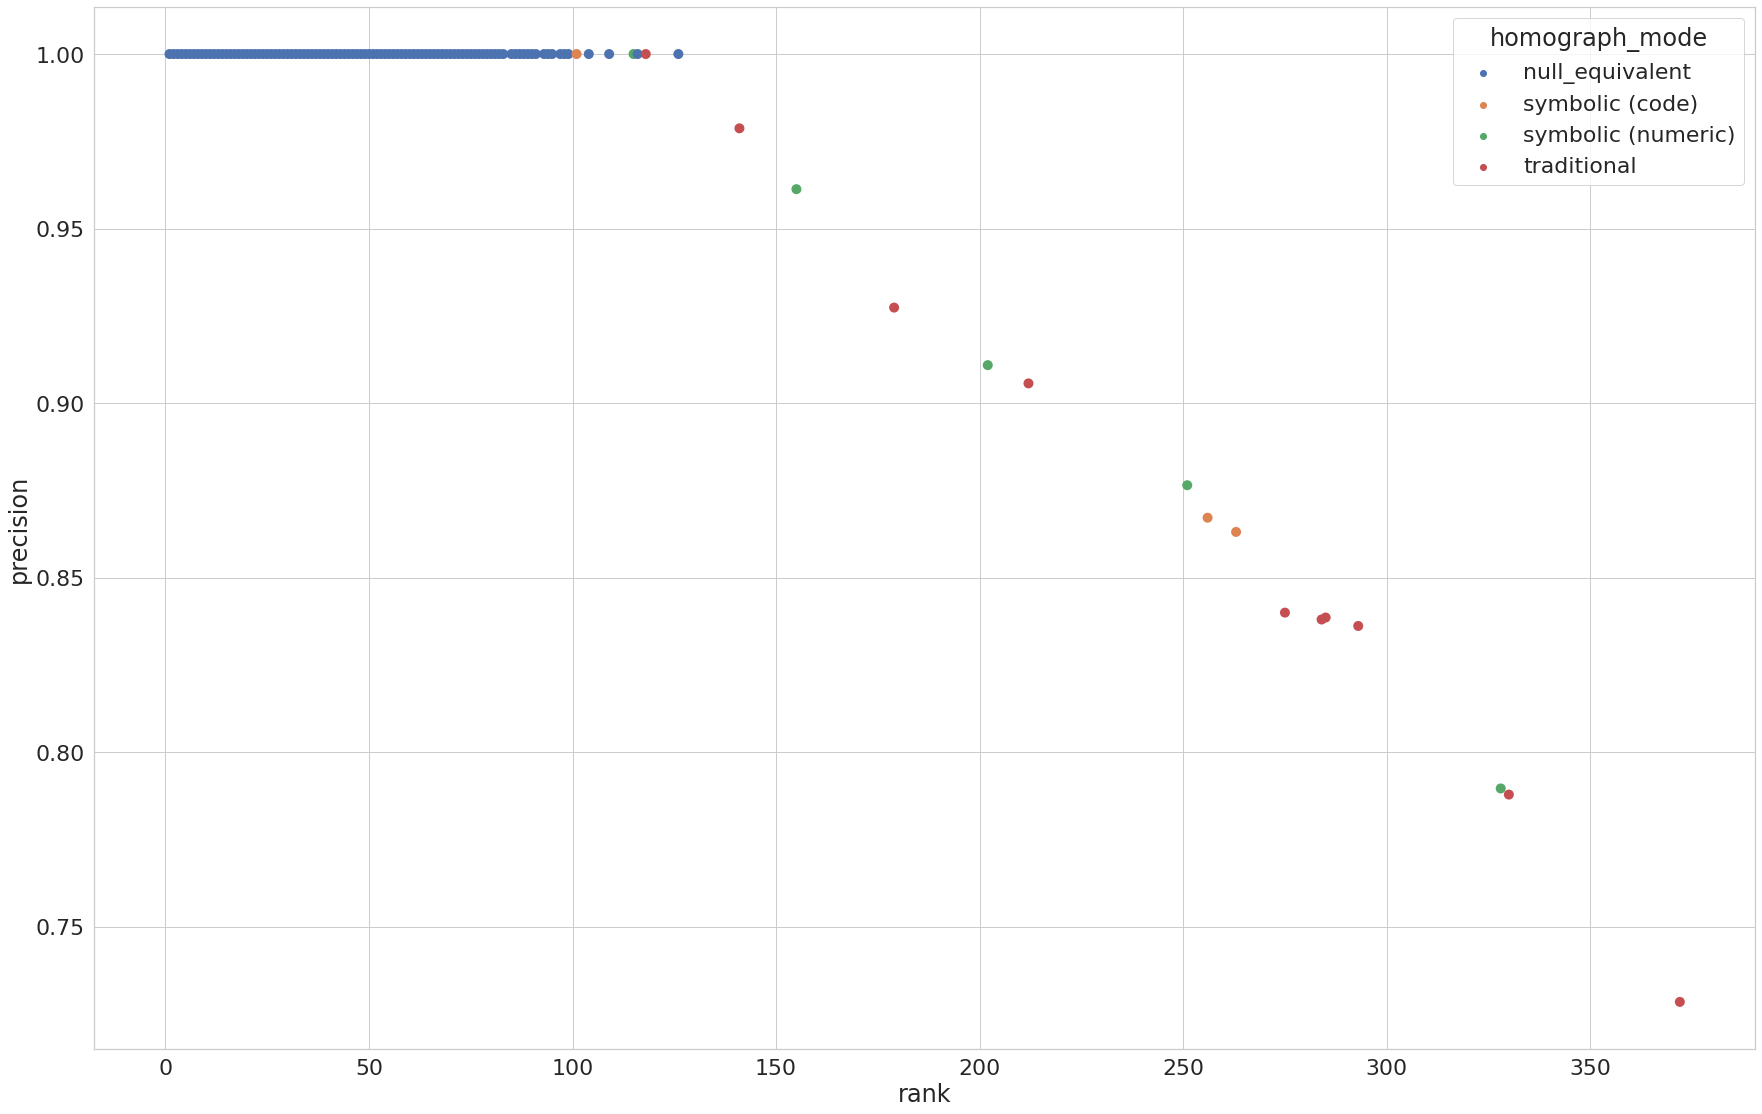

In [8]:
df = eval_dfs['homographs_all'].head(k*4).copy()
df['homograph_mode'] = df['homograph_mode'].map(mode_to_label)
sns.scatterplot(data=df, x='rank', y='precision', hue='homograph_mode', s=100, linewidth=0);plt.tight_layout()
plt.savefig('evaluation/synthetic_benchmark_large3/precision_all_types.svg')

In [9]:
for mode in df['homograph_mode'].unique():
    ranks = df[df['homograph_mode']==mode]['rank']
    print('For mode:', mode, 'the are:', len(ranks), 'discovered instances  in top-k and the average rank is:', ranks.mean())

ranks=df[df['homograph_mode'].isnull()]['rank']
print('For mode: NONE the are:', len(ranks), 'discovered instances in top-k and the average rank is:', ranks.mean())


For mode: null_equivalent the are: 100 discovered instances  in top-k and the average rank is: 51.33
For mode: nan the are: 0 discovered instances  in top-k and the average rank is: nan
For mode: symbolic (code) the are: 3 discovered instances  in top-k and the average rank is: 206.66666666666666
For mode: symbolic (numeric) the are: 5 discovered instances  in top-k and the average rank is: 210.2
For mode: traditional the are: 10 discovered instances  in top-k and the average rank is: 248.9
For mode: NONE the are: 282 discovered instances in top-k and the average rank is: 251.44326241134752


# Testing

In [7]:
eval_dfs['homographs_symbolic_numeric'].head(40)

,node,node_type,approximate_betweenness_centrality,is_homograph,homograph_mode,precision,recall,f1_score,rank
90672,1,cell,0.177691,True,homographs_symbolic_numeric,1.000000,0.01,0.019802,1
5270,968,cell,0.140023,False,NaN,0.500000,0.01,0.019608,2
5185,SVX,cell,0.133423,False,NaN,0.333333,0.01,0.019417,3
89789,42,cell,0.035355,False,NaN,0.250000,0.01,0.019231,4
4825,LS,cell,0.022201,False,NaN,0.200000,0.01,0.019048,5
5086,940,cell,0.020260,True,homographs_symbolic_numeric,0.333333,0.02,0.037736,6
98735,Wart Lichen,cell,0.014958,False,NaN,0.285714,0.02,0.037383,7
98647,Dot Lichen,cell,0.014913,False,NaN,0.250000,0.02,0.037037,8
131809,SUZ,cell,0.014708,False,NaN,0.222222,0.02,0.036697,9
92246,120,cell,0.013909,False,NaN,0.200000,0.02,0.036364,10


In [6]:
eval_dfs['homographs_symbolic_numeric'][eval_dfs['homographs_symbolic_numeric']['is_homograph']==True]

,node,node_type,approximate_betweenness_centrality,is_homograph,homograph_mode,precision,recall,f1_score,rank
90672,1,cell,0.177691,True,homographs_symbolic_numeric,1.000000,0.01,0.019802,1
5086,940,cell,0.020260,True,homographs_symbolic_numeric,0.333333,0.02,0.037736,6
131225,191,cell,0.003983,True,homographs_symbolic_numeric,0.056604,0.03,0.039216,53
131414,593,cell,0.002806,True,homographs_symbolic_numeric,0.054054,0.04,0.045977,74
131213,181,cell,0.002087,True,homographs_symbolic_numeric,0.053763,0.05,0.051813,93
...,...,...,...,...,...,...,...,...,...
131395,564,cell,0.000247,True,homographs_symbolic_numeric,0.030418,0.96,0.058968,3156
131461,676,cell,0.000247,True,homographs_symbolic_numeric,0.030725,0.97,0.059564,3157
131337,404,cell,0.000098,True,homographs_symbolic_numeric,0.012002,0.98,0.023714,8165
131288,303,cell,0.000098,True,homographs_symbolic_numeric,0.012123,0.99,0.023954,8166
